In [1]:
import networkx as nx
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence

import re 
import numpy as np
from networkx.algorithms.approximation import traveling_salesman_problem
from dotenv import load_dotenv

import googlemaps
import os
from geopy.geocoders import Nominatim
import time
import geopandas as gpd

import matplotlib.pyplot as plt
import contextily as ctx

load_dotenv("hidden.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
maps_API_KEY = os.getenv('maps_API_KEY')
gmaps = googlemaps.Client(key=maps_API_KEY) 
geolocator = Nominatim(user_agent="tsp")

In [10]:
## First we create a prompt to ask for either landmarks, towns, cities, within the given place for the given number 

def get_location(): 

    location = input("Enter the location, this can be a country, city, or region: ")
    number = int(input("Enter the number of locations to visit: "))
    node_type = input("Enter type of place to include e.g. countries, towns, landmarks, etc:")

    prompt1 = PromptTemplate(
        input_variables=["number", "location", "node_type"],
        template="List {number} {node_type} to visit in {location}. One per line, itemized."
    )

    chat = ChatOpenAI(model="gpt-4", temperature=1.0)
    chain = prompt1 | chat
    response = chain.invoke({"number": number,"location": location, "node_type": node_type})
    nodes = re.findall(r"\d+\.\s*(.+)", response.content)
    nodes = [node + ", " + location for node in nodes]
    
    return nodes

In [18]:
def create_graph(nodes):

    number = len(nodes)
    prompt2 = PromptTemplate(
        input_variables=['node1'],
        template="Tell me the longitude and latitude of {node1}. In this format: (longitude, latitude)."
        )

    prompt3 = PromptTemplate(
        input_variables=['node1', 'node2'],
        template="Tell me the distance from {node1} to {node2} in km. Only the number please."
        )

    G = nx.complete_graph(number)
    labels = {i: nodes[i] for i in range(number)}
    positions = {}

    for i in range(number): 
        chat  = ChatOpenAI(model="gpt-4", temperature=1.0)
        chain = prompt2 | chat
        response2 = chain.invoke({'node1': nodes[i]}).content
        match = re.search(r"\(?\s*(-?\d+\.\d+)\s*,\s*(-?\d+\.\d+)\s*\)?", response2)
        if match:
            lat = float(match.group(1))
            lon = float(match.group(2))
        positions[i] = (lat, lon)
        for j in range(i + 1, number): 
            chain = prompt3 | chat
            response3 = chain.invoke({"node1": nodes[i], "node2": nodes[j]}).content
            G[i][j]['weight'] = float(response3)


    # Create a bigger figure
    plt.figure(figsize=(7, 5))
    nx.draw(G, pos=positions, with_labels=False, node_color='lightblue', node_size=1000)
    nx.draw_networkx_labels(G, pos=positions, labels=labels, font_size=12)
    nx.draw_networkx_edge_labels(G, pos=positions,
        edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

    plt.title("Weighted Graph (TSP Nodes)")
    plt.show()

    return G, labels, positions

In [19]:
def solve_path(G, labels, positions):
    tsp_path = traveling_salesman_problem(G, weight='weight', cycle=False)
    print("TSP Approximate Path:", [labels[node] for node in tsp_path])

    # Draw TSP path over the existing graph
    tsp_edges = list(zip(tsp_path, tsp_path[1:]))

    start_node = tsp_path[0]
    node_colors = ['red' if node == start_node else 'skyblue' for node in G.nodes()]
    # Plot again with highlighted path
    plt.figure(figsize=(7, 5))
    nx.draw(G, positions, with_labels=False, node_color=node_colors, node_size=1000, edge_color='gray')
    nx.draw_networkx_labels(G, positions, labels, font_size=14, font_weight='bold')
    nx.draw_networkx_edge_labels(G, positions, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

    # Highlight the TSP path in red
    nx.draw_networkx_edges(G, pos=positions, edgelist=tsp_edges, edge_color='red', width=3)

    plt.title("TSP Path (Approximate)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return


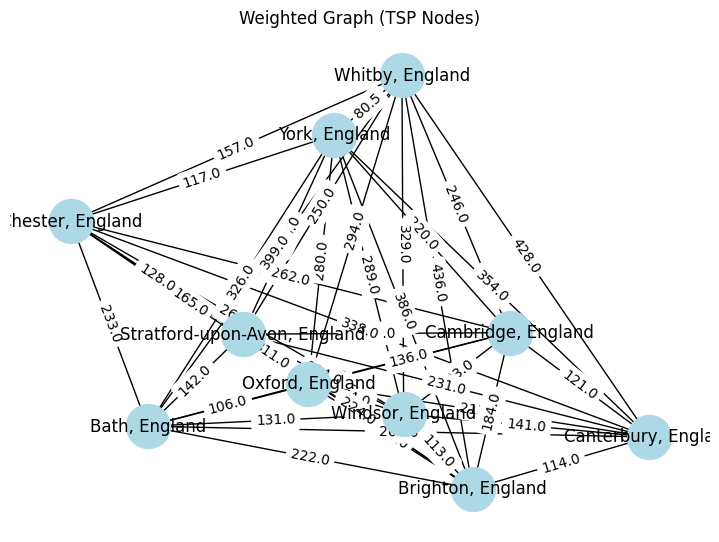

TSP Approximate Path: ['Cambridge, England', 'Canterbury, England', 'Brighton, England', 'Windsor, England', 'Oxford, England', 'Bath, England', 'Stratford-upon-Avon, England', 'Chester, England', 'York, England', 'Whitby, England']


/var/folders/qw/j_xx4gx91jg3dsbgqgr6bf8r0000gn/T/ipykernel_7182/3687795560.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


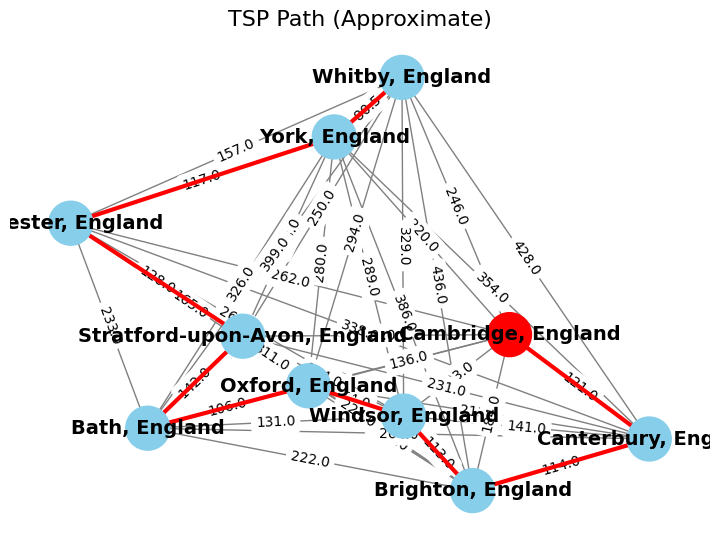

In [20]:
nodes = get_location()
G, labels, positions = create_graph(nodes)
solve_path(G, labels, positions)